In [383]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import shap
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb
import optuna

In [384]:
df = pd.read_csv('data\zscore_data.csv')
df['date'] = pd.to_datetime(df['date'])
df['OT'] = df['OT'].shift(-1)

timestamps = pd.date_range(
    start="2017-07-01", 
    end="2018-06-26", 
    freq="MS"
)

win_idx = 11
divided_date = timestamps[win_idx]

In [385]:
valid_date = divided_date - pd.DateOffset(months=1)
test_date = divided_date + pd.DateOffset(months=1)

train = df[df['date'] < valid_date]
valid = df[(df['date'] >= valid_date) & (df['date'] < divided_date)]
test = df[(df['date'] >= divided_date) & (df['date'] < test_date)]

target_col = "OT"
features = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL"]

In [387]:
def create_features(df):
    df = df.assign(hour = df['date'].dt.hour,
                   day_of_week = df['date'].dt.dayofweek,
                   day_of_month = df['date'].dt.day)
    
    window_sizes = [12, 24, 24 * 7]
    for col in features + [target_col]:
        for ws in window_sizes:
            df[f"{col}_rolling_mean_{ws}"] = df[col].rolling(ws).mean().shift(1)
            df[f"{col}_rolling_std_{ws}"] = df[col].rolling(ws).std().shift(1)
    
    # 滞后特征
    for lag in [1, 2, 12, 24, 48, 336]:
        df[f"OT_lag_{lag}"] = df[target_col].shift(lag)
    
    return df

In [388]:
train_fe = create_features(train).set_index('date')
valid_fe = create_features(valid).set_index('date')
test_fe = create_features(test).set_index('date')

X_train, y_train = train_fe.drop(columns=[target_col]), train_fe[target_col]
X_valid, y_valid = valid_fe.drop(columns=[target_col]), valid_fe[target_col]
X_test, _ = test_fe.drop(columns=[target_col]), test_fe[target_col]

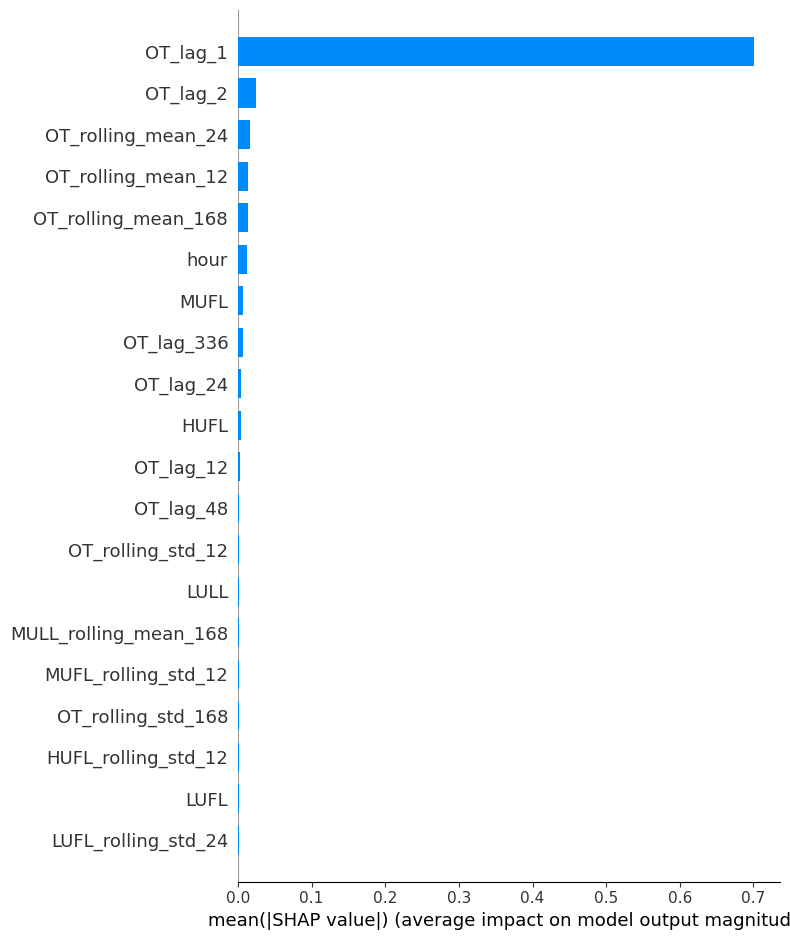

In [389]:
initial_model = lgb.LGBMRegressor(verbosity=-1)
initial_model.fit(X_train, y_train)

explainer = shap.TreeExplainer(initial_model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=20)

def dynamic_feature_selection(shap_values, X, percentile=95):
    importance = np.abs(shap_values).mean(axis=0)
    sorted_idx = np.argsort(importance)[::-1]
    cumulative = np.cumsum(importance[sorted_idx])
    threshold = cumulative[-1] * percentile / 100
    selected = cumulative <= threshold
    return X.columns[sorted_idx][selected]

selected_features = dynamic_feature_selection(shap_values, X_train)
X_train_selected = X_train[selected_features]
X_valid_selected = X_valid[selected_features]
X_test_selected = X_test[selected_features]

In [390]:
# Optuna调参
def objective(trial):
    params = {
        "objective": "regression",
        "metric": "mae",
        'verbosity': -1,
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 24, 64, step=8),
        "max_depth": trial.suggest_int("max_depth", 4, 8), 
        "min_child_samples": trial.suggest_int("min_child_samples", 100, 300),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.7, 0.9)
    }

    
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train_selected, y_train,
              eval_set=[(X_valid_selected, y_valid)])
    
    pred = model.predict(X_valid_selected)
    return mean_absolute_error(y_valid, pred)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

[I 2025-05-23 23:06:26,642] A new study created in memory with name: no-name-b134d21d-1f9e-40d8-9a60-20a3c7200fe5
[I 2025-05-23 23:06:26,754] Trial 0 finished with value: 0.057816514369912926 and parameters: {'learning_rate': 0.03083261920468028, 'num_leaves': 24, 'max_depth': 6, 'min_child_samples': 291, 'feature_fraction': 0.7623904673423837}. Best is trial 0 with value: 0.057816514369912926.
[I 2025-05-23 23:06:26,840] Trial 1 finished with value: 0.05738098307843175 and parameters: {'learning_rate': 0.08248303812157594, 'num_leaves': 64, 'max_depth': 7, 'min_child_samples': 141, 'feature_fraction': 0.7057012959075627}. Best is trial 1 with value: 0.05738098307843175.
[I 2025-05-23 23:06:26,929] Trial 2 finished with value: 0.05615292762460478 and parameters: {'learning_rate': 0.06363770758748655, 'num_leaves': 56, 'max_depth': 7, 'min_child_samples': 187, 'feature_fraction': 0.8278460272166202}. Best is trial 2 with value: 0.05615292762460478.
[I 2025-05-23 23:06:26,985] Trial 3 fi

In [391]:
best_model = lgb.LGBMRegressor(**study.best_params, verbose=-1)
best_model.fit(X_train_selected, y_train)
X_test_selected = X_test_selected.interpolate(
    method='linear',
    limit_direction='both'
)
lgb_pred = best_model.predict(X_test_selected)

In [392]:
np.savez(f'lgbm_pred/lgbm_pred_window_{win_idx}.npz', pred=lgb_pred)